# Makemore Part 2: MLP

In [1]:
# In bigram model, we only take one previous character as a reference to predict the next character
# the words produced are not very good
# If we try to take 2 characters as context, we have 27*27 possibilities
# If we try to take 3 characters as context, we have 27*27*27 possibilities
# So we try MLP

In [2]:
# Bengio et al. 2003 Paper 
# A Neural Probabilistic Language Model

## Re-Building the dataset

In [3]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [5]:
len(words)

32033

In [6]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [7]:
# Build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words:
    #print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix]

X = torch.tensor(X)
Y = torch.tensor(Y)

In [137]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [138]:
Xtr.shape, Xtr.dtype, Ytr.shape, Ytr.dtype

(torch.Size([182580, 3]), torch.int64, torch.Size([182580]), torch.int64)

## Implementing the embedding lookup table

In [139]:
C = torch.randn((27, 2))

In [140]:
# We can index into like this 
C[5]
# as well as
C[torch.tensor([5,6,7,7,7])]

tensor([[ 0.5649, -1.5296],
        [ 1.0453, -0.1722],
        [ 0.4850, -0.2281],
        [ 0.4850, -0.2281],
        [ 0.4850, -0.2281]])

In [141]:
# But we do this
emb = C[X]
emb.shape
# So for every one of X we have retrieved its embedding vector

torch.Size([228146, 3, 2])

## Implementing the hidden layer + internals of torch.Tensor: storage, views

In [142]:
W1 = torch.rand((6, 100)) #6 input, 100 neurons
b1 = torch.randn(100)

In [143]:
# We need to somehow make the shape of emb from 32,3,2 to 32, 6, 
# So we can multiply that emb with W1 which is shape 6, 100
# emb[:, 0, :].shape  output-> torch.Size([32, 2])
# This gives us 1 of the embeddings, we need to retrieve 3 of them and concat them
# torch.cat([emb[:, 0, :],  emb[:, 1, :],  emb[:, 2, :]], 1).shape
# But instead of doing this manually, unbind the 1st dimension and concat it like this
# torch.cat(torch.unbind(emb, 1), 1).shape # This is inefficient -> new memory creation
# But there is a better way of doing it
# ---
# a = torch.arange(18)
# a
# a.view(2,9); this operation is very efficient; storage remains same but view can change
# So we can do
# print(emb.shape) => 32, 3, 2
# emb.view(32, 6).shape => 32, 6

In [144]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # Put -1 instead of hard-coding it as 32, this way PyTorch will infer it as 32
h

tensor([[ 0.9279,  0.9997,  0.9999,  ...,  0.9961,  0.9963,  0.9992],
        [ 0.9033,  0.9787,  0.9920,  ...,  0.9580,  0.8529,  0.9900],
        [ 0.5095, -0.8151,  0.8984,  ..., -0.7226, -0.1602, -0.6187],
        ...,
        [ 0.3052,  0.1564,  0.8114,  ..., -0.4260, -0.3958,  0.0527],
        [ 0.3751,  0.5365,  0.7497,  ..., -0.3541, -0.7342, -0.2803],
        [-0.2427,  0.3270,  0.8466,  ..., -0.3454, -0.5409,  0.7426]])

In [145]:
h.shape

torch.Size([228146, 100])

## Implementing the  output layer and Negative log likelihood loss

In [146]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [147]:
logits = h @ W2 + b2
logits.shape

torch.Size([228146, 27])

In [148]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims=True)
prob.shape

torch.Size([228146, 27])

In [149]:
loss = -prob[torch.arange(prob.shape[0]), Y].log().mean() # Negative log likelihood loss
loss

tensor(15.4720)

## Summary of the network

In [151]:
Xtr.shape, Ytr.shape # Dataset

(torch.Size([182580, 3]), torch.Size([182580]))

In [212]:
g = torch.Generator().manual_seed(2147483647) # For reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.rand((30, 200), generator=g) #(3*10, 300) 30 inputs, 200 neuron output 
b1 = torch.randn(200, generator=g)
W2 = torch.rand((200, 27), generator=g) 
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [213]:
sum(p.nelement() for p in parameters) # Number of parameters in total

11897

In [160]:
# Forward pass
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2
counts = logits.exp()
# prob = counts / counts.sum(1, keepdims=True)
# loss = -prob[torch.arange(32), Y].log().mean() 
# loss

## Introducing F.cross_entropy and why

In [161]:
# Instead of the above loss, we can use cross-entropy
# Never in practice write the above code, as it creates new tensors in memory 
# Backward pass is simpler with cross-entropy, even the forward pass
# And numerically well behaved 
loss = F.cross_entropy(logits, Y)
loss

tensor(6.1746)

## Implementing the training loop, overfitting one batch & Mini-batch on full dataset

In [214]:
for p in parameters:
    p.requires_grad = True

In [169]:
for i in range(10000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # Forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2
    counts = logits.exp()
    loss = F.cross_entropy(logits, Ytr[ix])
    # if i % 1000 == 0:
    #     print(loss.item())|
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    for p in parameters:
        p.data += -0.001 * p.grad

print(loss.item())

1.9691802263259888


In [171]:
emb = C[Xtr] # (228146, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (228146, 100)
logits = h @ W2 + b2
counts = logits.exp()
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.2423, grad_fn=<NllLossBackward0>)

In [172]:
emb = C[Xdev] # (228146, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (228146, 100)
logits = h @ W2 + b2
counts = logits.exp()
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.2464, grad_fn=<NllLossBackward0>)

## Finding a good initial learning rate

In [182]:
lre = torch.linspace(-3, 0, 1000) # 1000 steps between -3 and 0
lrs = 10 ** lre # 1000 steps between 10^-3 and 10^0
# lrs

In [215]:
lri = []
lossi = []
stepi = []

In [220]:
for i in range(50000):

    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # Forward pass
    emb = C[Xtr[ix]] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2
    counts = logits.exp()
    loss = F.cross_entropy(logits, Ytr[ix])
    # if i % 100 == 0:
    #     print(loss.item())
    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    #update
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # Track stats
    # lri.append(lre[i])
    lossi.append(loss.log10().item())
    stepi.append(i)
    
print(loss.item())

2.051547050476074


In [221]:
emb = C[Xtr] # (228146, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (228146, 100)
logits = h @ W2 + b2
counts = logits.exp()
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.0784, grad_fn=<NllLossBackward0>)

In [222]:
emb = C[Xdev] # (228146, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (228146, 100)
logits = h @ W2 + b2
counts = logits.exp()
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1210, grad_fn=<NllLossBackward0>)

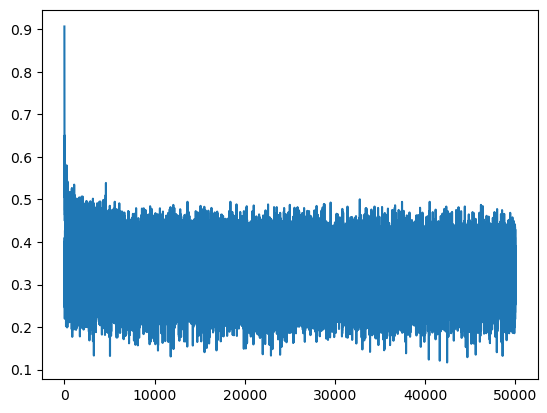

In [223]:
plt.plot(stepi, lossi)
plt.show()

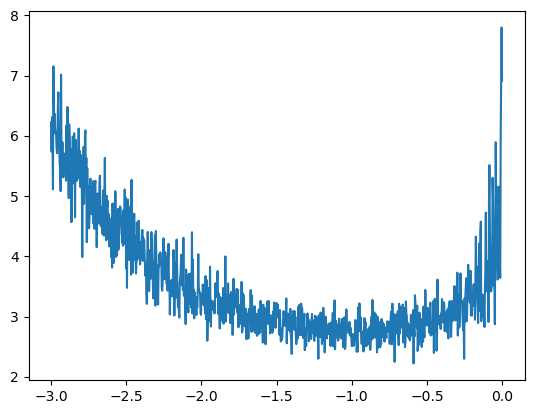

In [131]:
plt.plot(lri, lossi)
plt.show()

In [133]:
# From this we can deduce that 10^-1 or 0.1 is a good initial learning rate
# After a few iterations at learning rate 0.1, we can reduce it to 0.01
# Run that for 10000 iterations and then again reduce it, keep going till learning rate is 0.001

## Splitting up the dataset into train/val/test splits and why

In [134]:
# To not overfit the data
# Split the data into
# Training split (used to otrain the parameters, dev/validation split (used to train hyperparameters), test split (Evaluate the performance of the model)
# 80%, 10%, 10%

In [136]:
# Done above

## Experiment: larger hidden later

In [173]:
# This model currently only has 3481 parameters which is very small and is underfitting the dat

## Visualizing the embedding vector

In [198]:
# Right now the embedding size is 2 so we can visaulize them

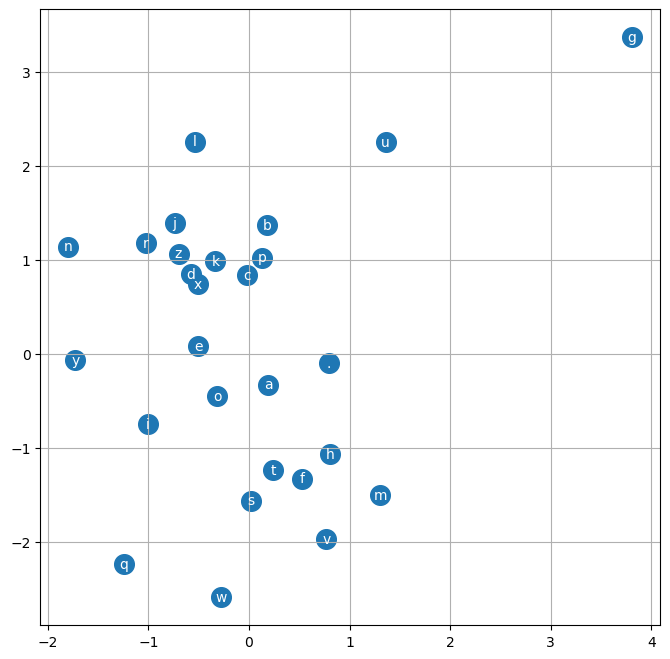

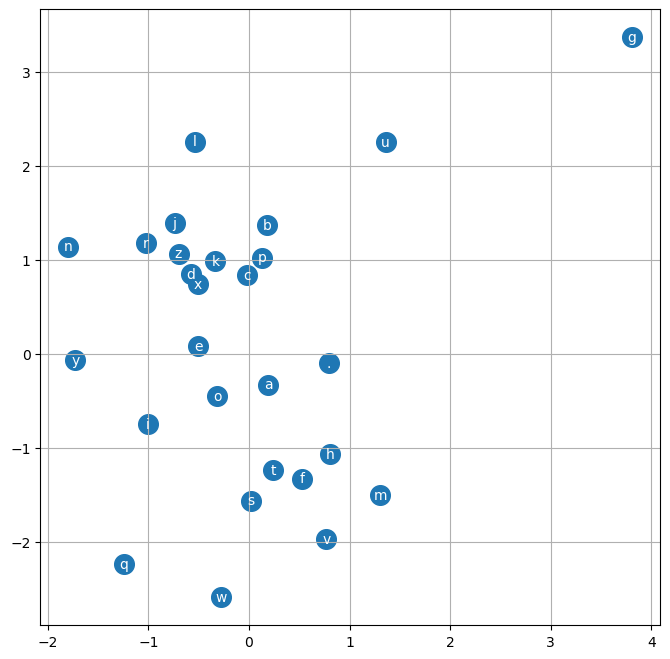

In [201]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
plt.show()

## Experiment: Larger embedding size

In [202]:
# instead of C = torch.randn((27, 2)) this is @ dimensional
# We do (27, 10) this is 10 dimensional

## Final Code and sample from the model

In [224]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182437, 3]) torch.Size([182437])
torch.Size([22781, 3]) torch.Size([22781])
torch.Size([22928, 3]) torch.Size([22928])


In [225]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [226]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [227]:
for p in parameters:
  p.requires_grad = True

for i in range(200000):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))
  
  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  
  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  # stepi.append(i)
  # lossi.append(loss.log10().item())

#print(loss.item())

In [228]:
# Train Loss
emb = C[Xtr] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1313, grad_fn=<NllLossBackward0>)

In [229]:
# Dev Loss
emb = C[Xdev] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1858, grad_fn=<NllLossBackward0>)

In [232]:
# Test Loss
emb = C[Xte] # (32, 3, 10)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Yte)
loss

tensor(2.1780, grad_fn=<NllLossBackward0>)

In [233]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [234]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

carmaizabelle.
khi.
milia.
atyah.
cassa.
jazhita.
deliah.
jarqui.
nerania.
chaiiy.
kaleigh.
ham.
joce.
quinn.
sulisea.
jadia.
watelogiefrynn.
jaxeenicsabee.
demiia.
gian.
